<a href="https://colab.research.google.com/github/rmr327/InterpretableMl/blob/main/Interpretable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Necessary Imports


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LogisticGAM, s, f
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings

# uncomment if library not installed
# !pip install pygam
# !pip install kaggle

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## Exploratory Data Analysis

In [75]:
# uncomment if data not downloaded
# !kaggle datasets download -d blastchar/telco-customer-churn
# !unzip telco-customer-churn.zip

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


> Lets drop customer ID and make total charges numeric.

In [76]:
# We will see below the Total charges column is of type object, lets change that
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# we can drop the customerid column as it should give us no new info
df = df.drop('customerID', axis=1)

df.dropna(inplace=True)

> Lets see the initial VIF

In [77]:
# check VIF of df
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For remaining categorical variables with more than two classes, use One-Hot Encoding
df = pd.get_dummies(df, drop_first=True).astype(float)

# Calculate VIF for each feature
# Prepare data for VIF calculation by dropping any NaN or infinite values
X = df.dropna()

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values.astype(float), i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  feature          VIF
0                           SeniorCitizen     1.155144
1                                  tenure     7.601061
2                          MonthlyCharges   866.100958
3                            TotalCharges    10.883913
4                             gender_Male     1.002126
5                             Partner_Yes     1.462989
6                          Dependents_Yes     1.382213
7                        PhoneService_Yes  1774.603920
8          MultipleLines_No phone service    60.960500
9                       MultipleLines_Yes     7.295768
10            InternetService_Fiber optic   148.578927
11                     InternetService_No          inf
12     OnlineSecurity_No internet service          inf
13                     OnlineSecurity_Yes     6.340993
14       OnlineBackup_No internet service          inf
15                       OnlineBackup_Yes     6.796884
16   DeviceProtection_No internet service          inf
17        

> Lets iteratively removce all VIF features > 10, since VIF > 10 suggests multicollinearity (which violates all of the models we will be using).

In [78]:
highest_vif = vif_data['VIF'].max()
while highest_vif > 10:
    highest_vif_col = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
    print(f"Removing {highest_vif_col} with VIF {highest_vif}")
    df = df.drop(highest_vif_col, axis=1)
    vif_data = pd.DataFrame()
    X = df.dropna()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values.astype(float), i) for i in range(X.shape[1])]
    highest_vif = vif_data['VIF'].max()

# Display the final VIF values
print("Final VIF values:")
print(vif_data)

Removing InternetService_No with VIF inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing OnlineSecurity_No internet service with VIF inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing OnlineBackup_No internet service with VIF inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing DeviceProtection_No internet service with VIF inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing TechSupport_No internet service with VIF inf


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Removing StreamingTV_No internet service with VIF inf
Removing PhoneService_Yes with VIF 1774.603919514802
Removing MonthlyCharges with VIF 46.83226048884237
Removing TotalCharges with VIF 20.23320694805964
Final VIF values:
                                  feature       VIF
0                           SeniorCitizen  1.373874
1                                  tenure  7.786966
2                             gender_Male  1.903769
3                             Partner_Yes  2.811888
4                          Dependents_Yes  1.949311
5          MultipleLines_No phone service  1.393740
6                       MultipleLines_Yes  2.450365
7             InternetService_Fiber optic  3.336396
8                      OnlineSecurity_Yes  1.900195
9                        OnlineBackup_Yes  2.085441
10                   DeviceProtection_Yes  2.242380
11                        TechSupport_Yes  2.022772
12                        StreamingTV_Yes  2.643017
13    StreamingMovies_No internet service  2.60

Looking at the result of the filtering above, we can see that the top features removed pointed at "no internet service", which indeed means the same thing and only needs to be represented once in the model.

> Lets check the data types of our columns

In [79]:
df.describe()

,SeniorCitizen,tenure,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,0.504693,0.482509,0.298493,0.096701,0.421928,0.440273,0.286547,0.344852,...,0.384386,0.216155,0.388367,0.209329,0.239619,0.592719,0.216297,0.336320,0.228100,0.265785
std,0.368844,24.545260,0.500014,0.499729,0.457629,0.295571,0.493902,0.496455,0.452180,0.475354,...,0.486484,0.411650,0.487414,0.406858,0.426881,0.491363,0.411748,0.472483,0.419637,0.441782
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> With the sweetviz library we can easily generate an interactive HTML file with simple EDA done for all variables.

In [80]:
# !pip install sweetviz
import sweetviz as sv

# Analyze the dataframe
report = sv.analyze(df)

# Display the report
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


> From the above code we can open the generated HTML to get a quick EDA on all vairables, as well as the association grpah below, which gives us a sense of how each variable is correlated with each other.

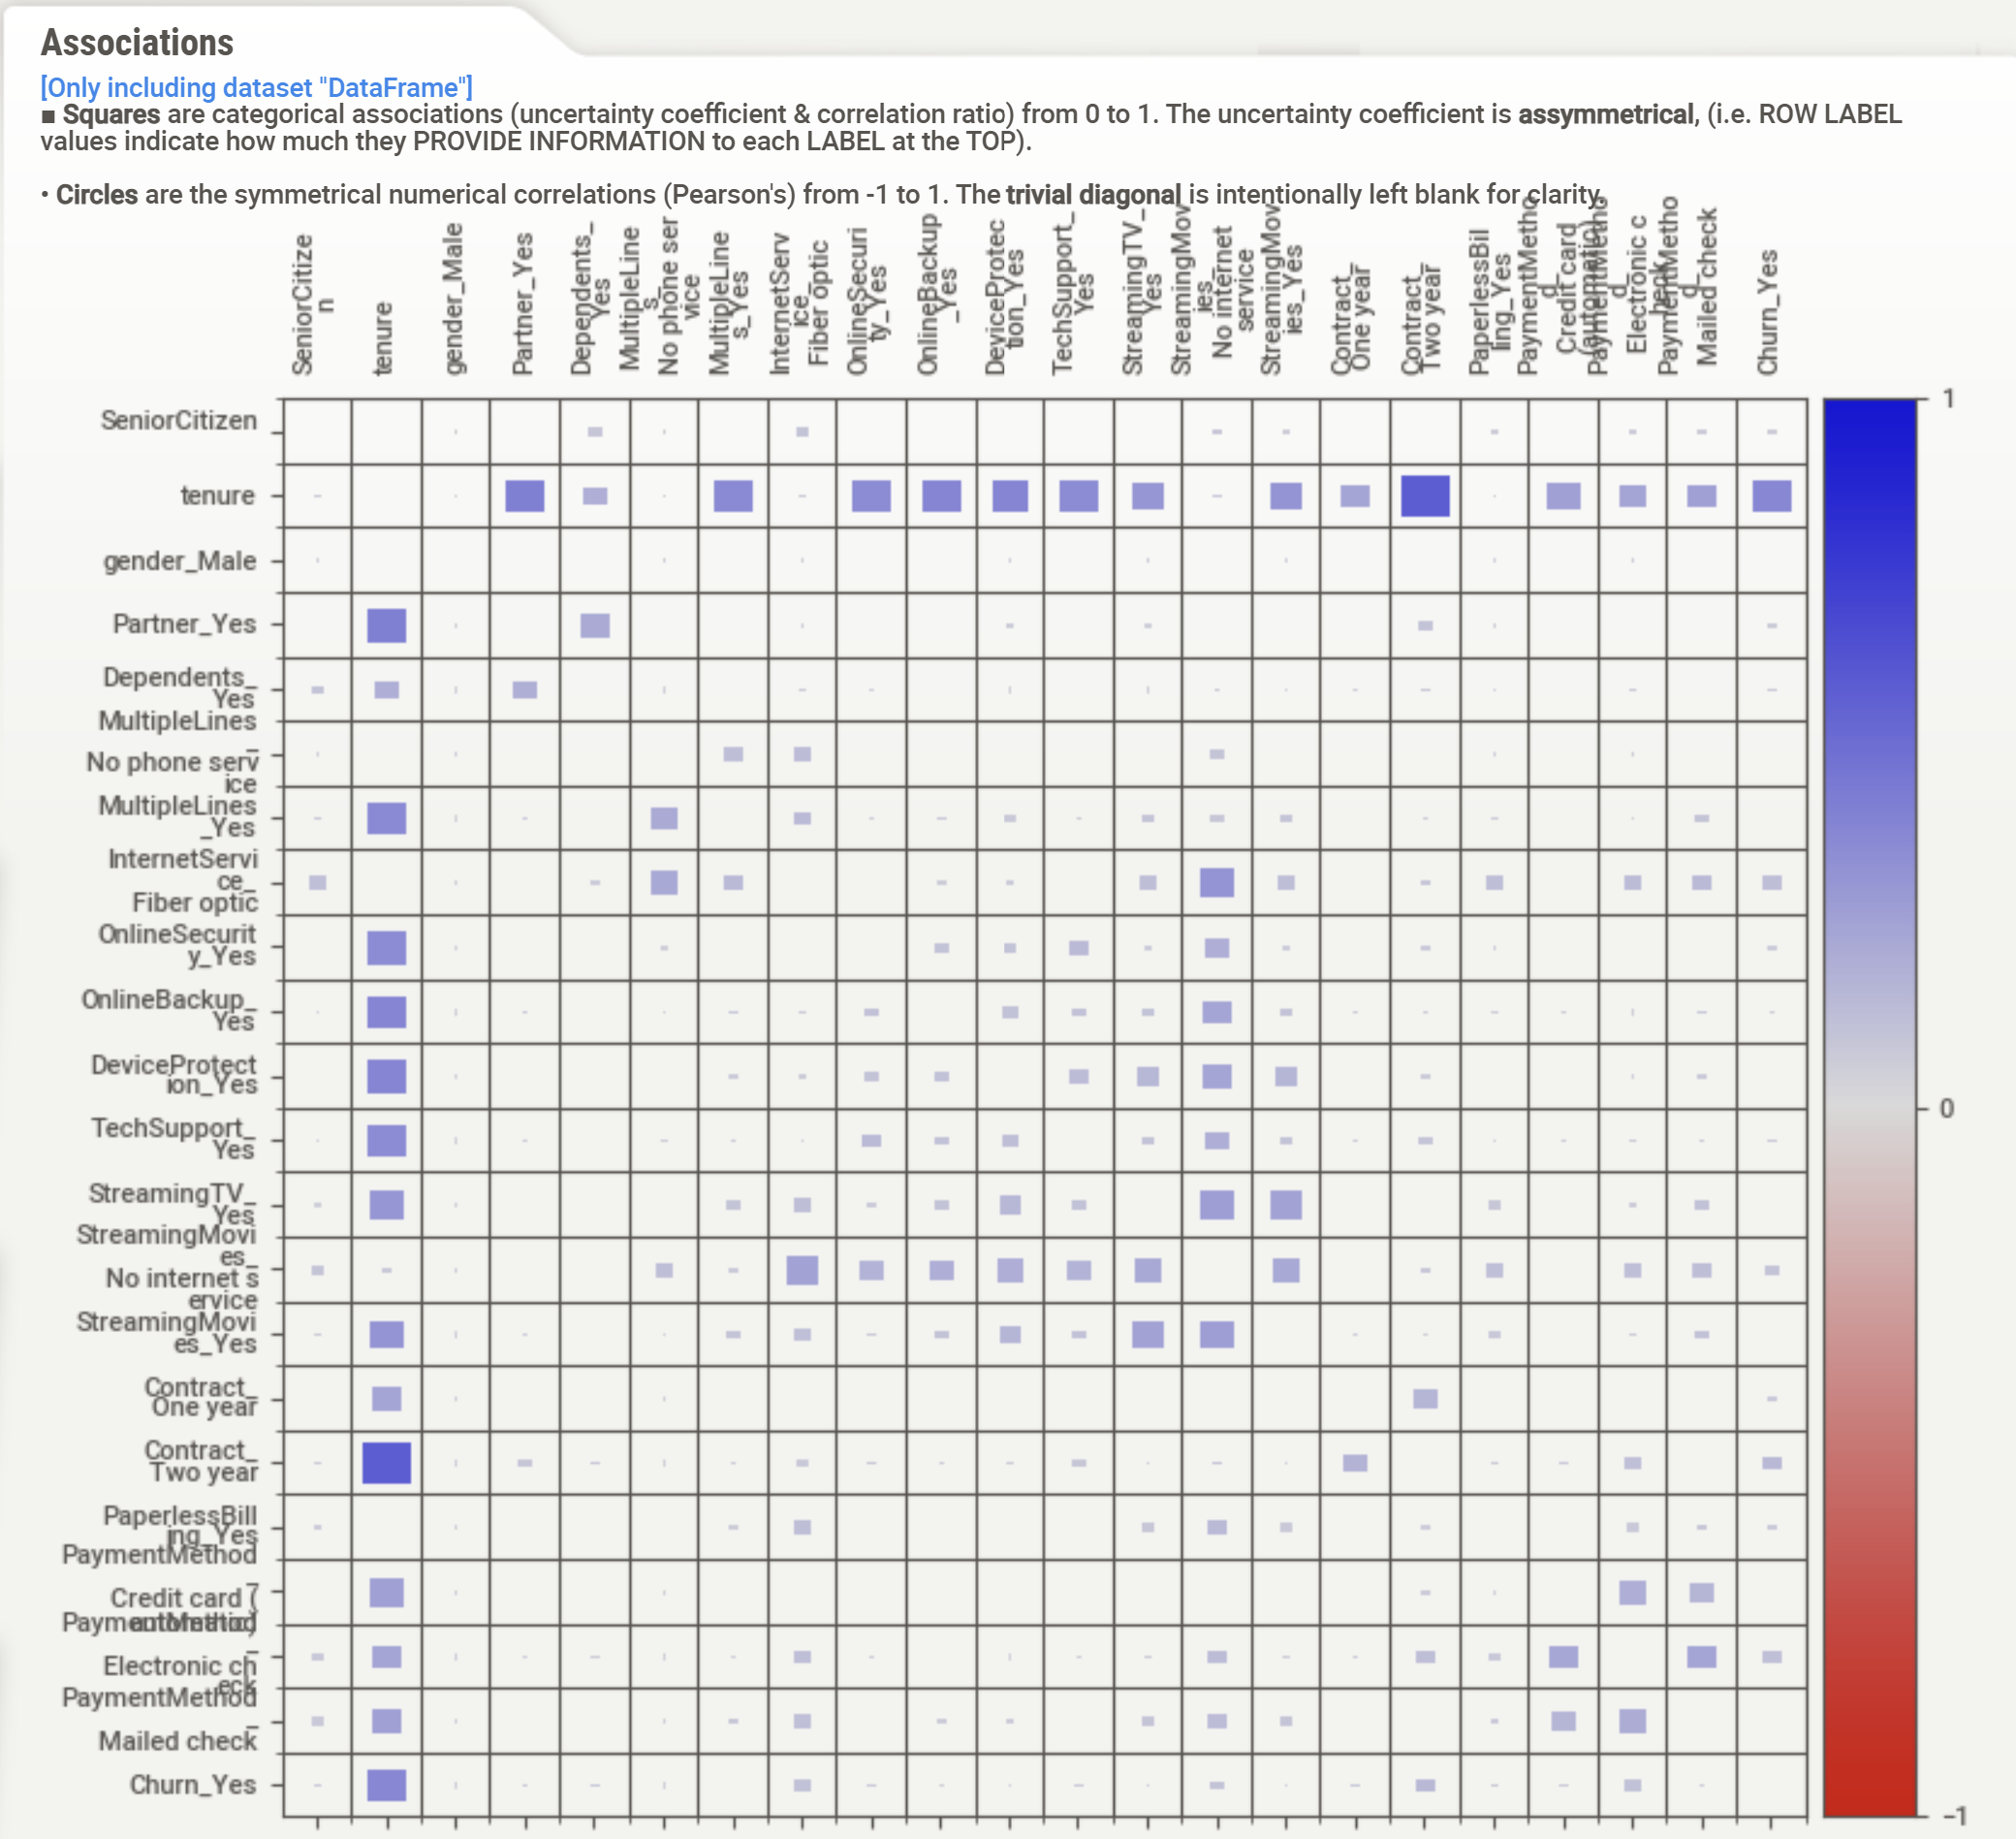

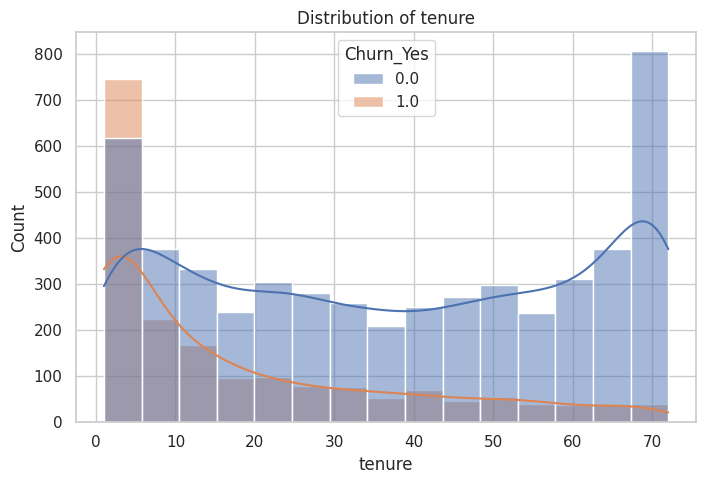

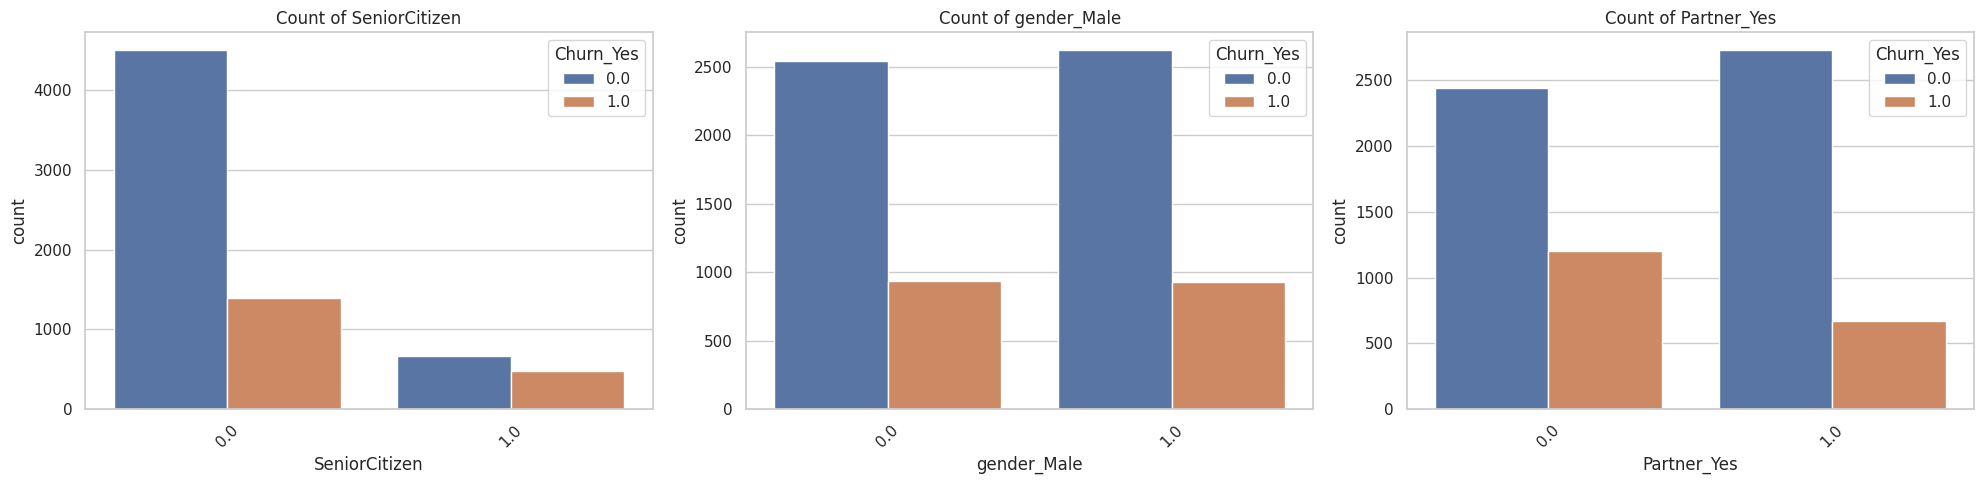

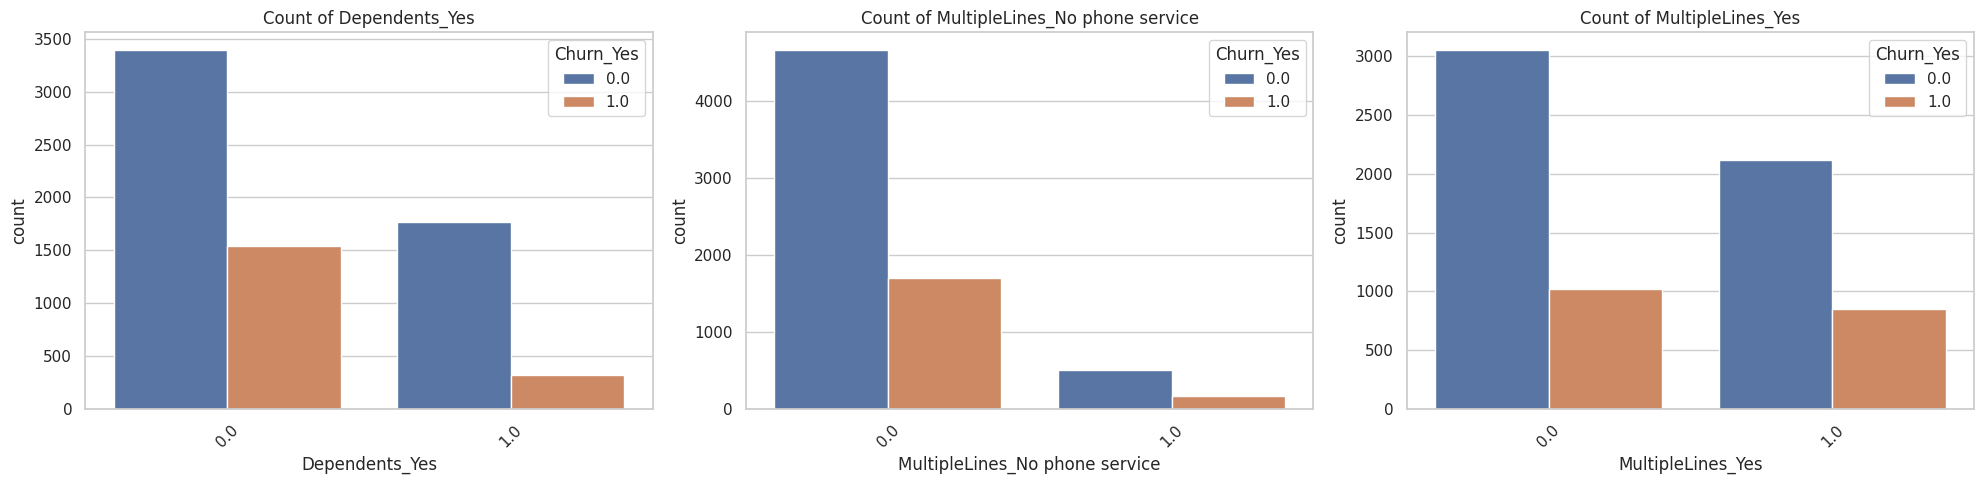

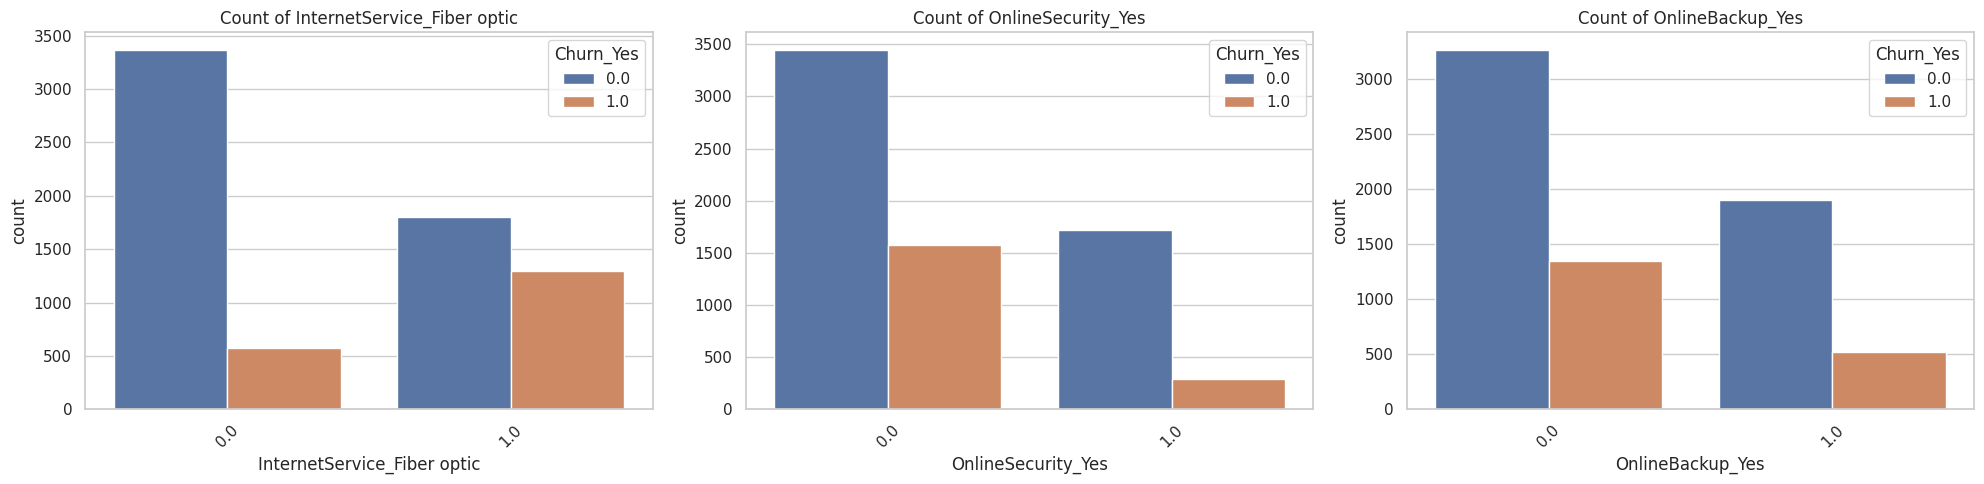

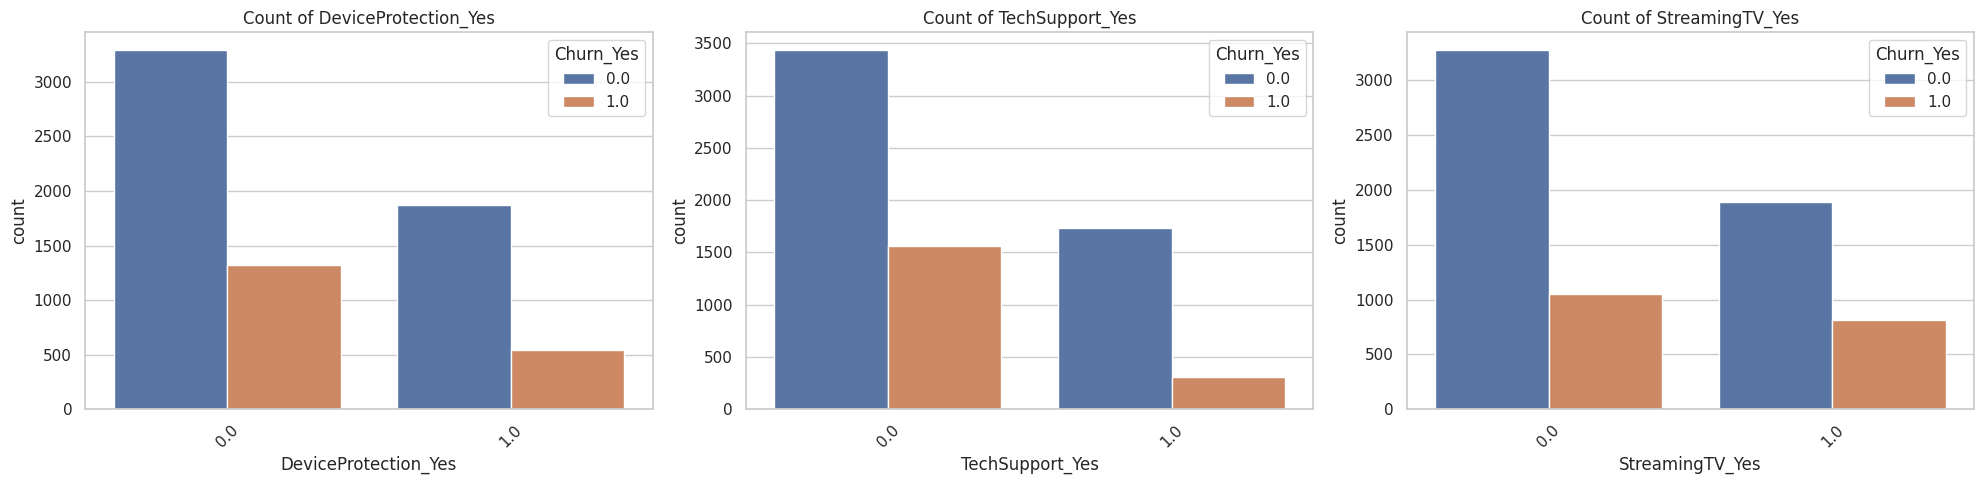

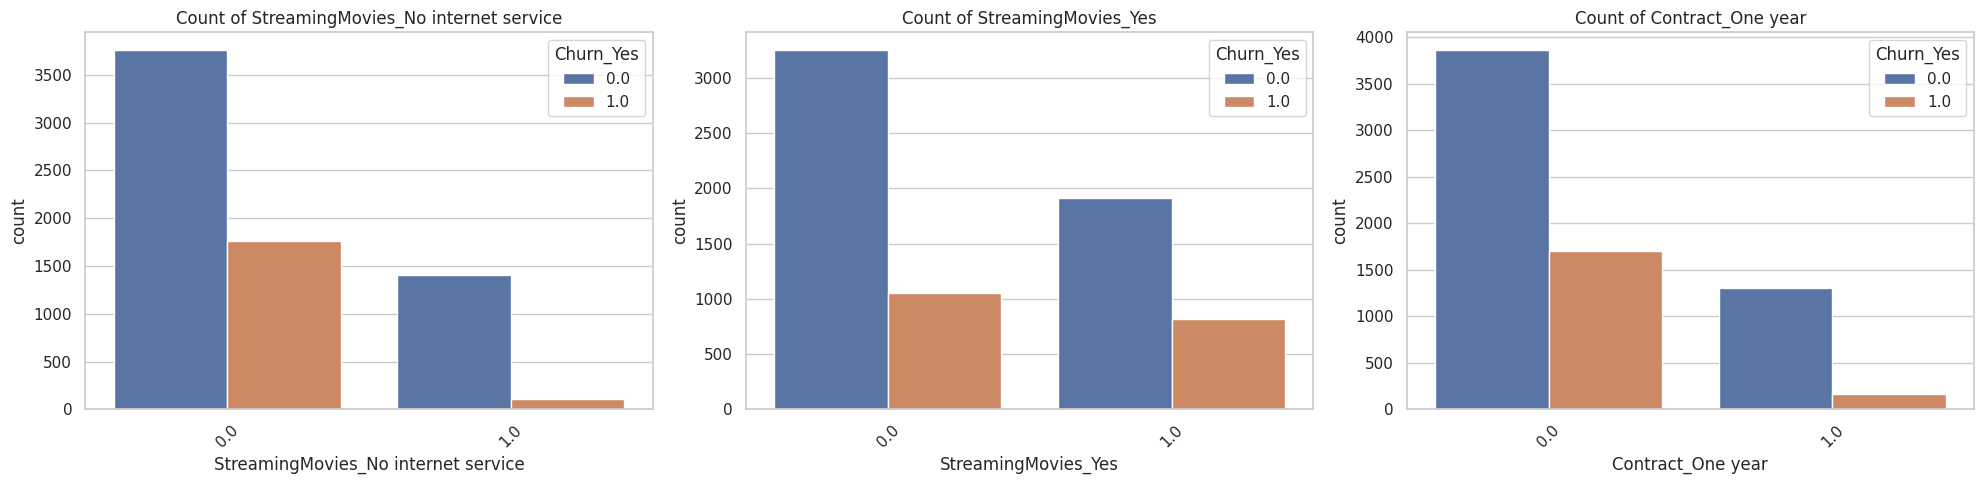

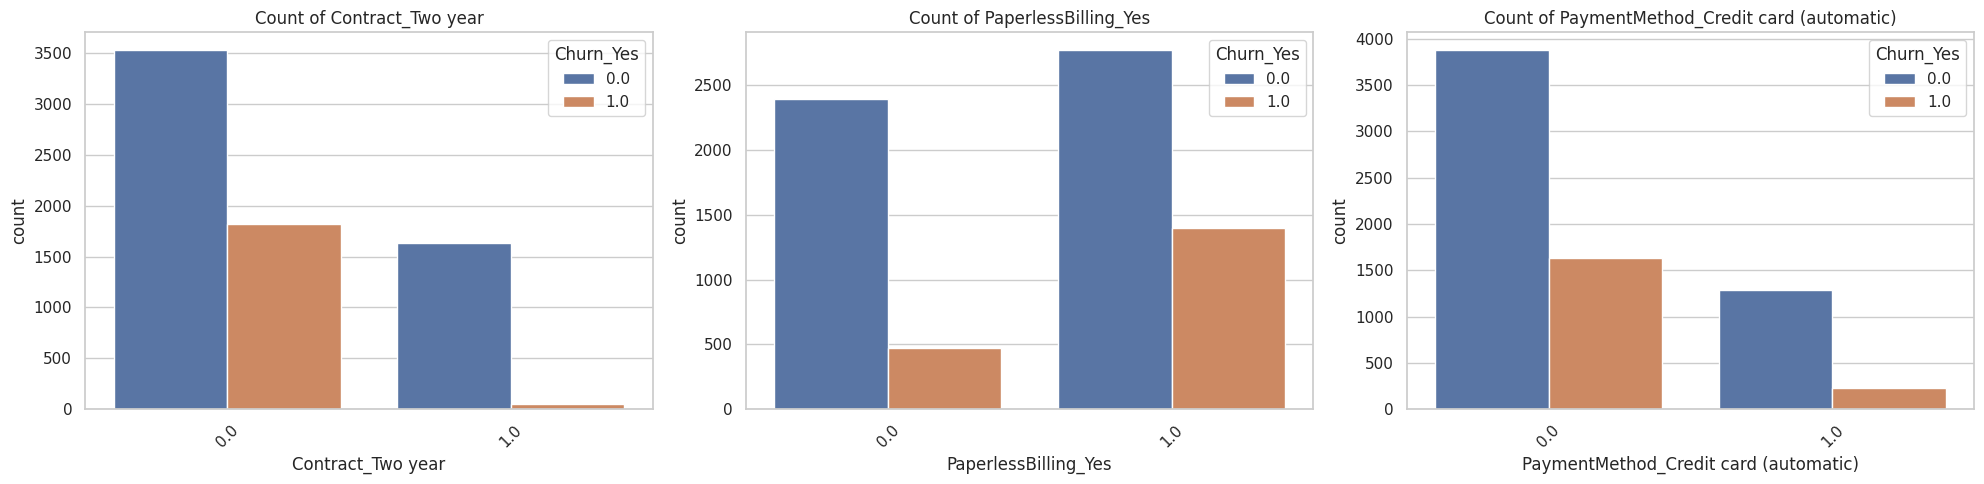

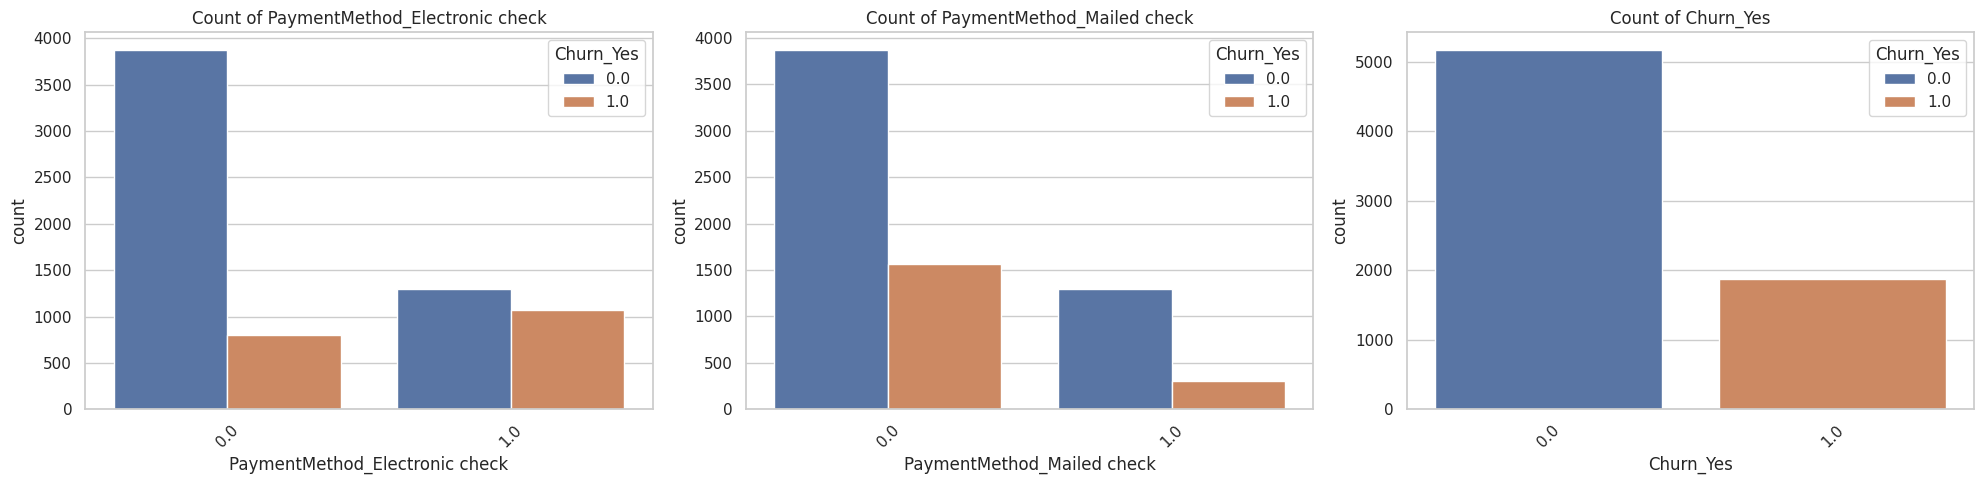

In [81]:
sns.set_theme(style="whitegrid")

# apps_sampled = apps.sample(frac=0.1, random_state=42)

numeric_columns = ['tenure']
cat_columns = [i for i in df.columns if i not in numeric_columns]
# making a filtered version of cat columns to avoid plot clutter
cat_columns_small = [i for i in cat_columns if df[i].nunique() < 10]
cat_columns_big = [i for i in cat_columns if df[i].nunique() >= 10]

# Plotting Numeric Columns
for i, column in enumerate(numeric_columns):
    if i % 3 == 0:  # Start a new row for every 3 plots
        plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, (i % 3) + 1)
    # sns.histplot(df[column], kde=True)
    sns.histplot(data=df, x=column, hue='Churn_Yes', kde=True)
    plt.title(f"Distribution of {column}")
    if (i % 3 == 2) or (i == len(numeric_columns) - 1):
        plt.tight_layout()
        plt.show()


# Plotting Categorical Columns
for i, column in enumerate(cat_columns_small):
      if i % 3 == 0:  # Start a new row for every 3 plots
          plt.figure(figsize=(20, 5))
      plt.subplot(1, 3, (i % 3) + 1)
      sns.countplot(x=column, hue='Churn_Yes', data=df)
      plt.title(f"Count of {column}")
      plt.xticks(rotation=45)
      if (i % 3 == 2) or (i == len(cat_columns) - 1):
          plt.tight_layout()
          plt.show()

## Linear Regression

In [87]:
# Separate features (X) and target (y)
X = df.drop(['Churn_Yes'], axis=1)
y = df['Churn_Yes']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Add a constant to the model (intercept)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit a linear regression model using statsmodels
linear_model = sm.OLS(y_train, X_train).fit()

# Display the summary of the linear regression model
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Churn_Yes   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     102.7
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        05:37:51   Log-Likelihood:                -2437.9
No. Observations:                5625   AIC:                             4920.
Df Residuals:                    5603   BIC:                             5066.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

> Lets see the coeficients in a graph

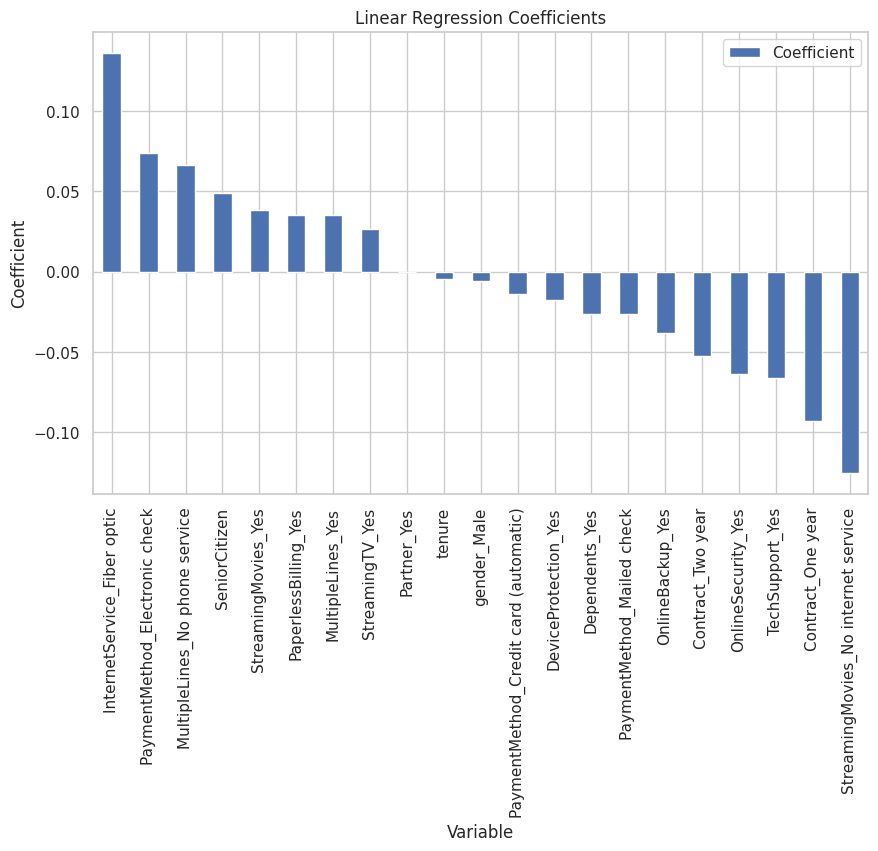

In [88]:
# plot the coeficients of the model for better visual
coef_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': linear_model.params[1:]})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
coef_df.plot(kind='bar', x='Variable', y='Coefficient', figsize=(10, 6))
plt.title('Linear Regression Coefficients')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()

> Coeficient Interpretations

Holding all else constant ->

Intercept:
0.3906: This is the baseline churn probability when all other variables are zero.

SeniorCitizen:
0.0487: Being a senior citizen increases the probability of churn by 4.87%.


tenure:
-0.0047: Each additional month of tenure decreases the probability of churn by 0.47%.

gender_Male:
-0.0060: Being male slightly decreases the probability of churn by 0.60%, but this is not statistically significant (p-value = 0.547).

Partner_Yes:
4.733e-05: Having a partner has a negligible effect on churn probability, and it’s not statistically significant (p-value = 0.997).

Dependents_Yes:
-0.0265: Having dependents decreases the probability of churn by 2.65%.

MultipleLines_No phone service:
0.0662: Not having phone service increases the probability of churn by 6.62%.

MultipleLines_Yes:
0.0350: Having multiple lines increases the probability of churn by 3.50%.

InternetService_Fiber optic:
0.1365: Using fiber optic internet increases the probability of churn by 13.65%.

OnlineSecurity_Yes:
-0.0637: Having online security decreases the probability of churn by 6.37%.

OnlineBackup_Yes:
-0.0380: Having online backup decreases the probability of churn by 3.80%.

DeviceProtection_Yes:
-0.0179: Having device protection decreases the probability of churn by 1.79%, but this is not statistically significant (p-value = 0.162).

TechSupport_Yes:
-0.0663: Having tech support decreases the probability of churn by 6.63%.

StreamingTV_Yes:
0.0263: Having streaming TV increases the probability of churn by 2.63%.

StreamingMovies_No internet service:
-0.1251: Not having internet service decreases the probability of churn by 12.51%.

StreamingMovies_Yes:
0.0382: Having streaming movies increases the probability of churn by 3.82%.

Contract_One year:
-0.0931: Having a one-year contract decreases the probability of churn by 9.31%.

Contract_Two year:
-0.0526: Having a two-year contract decreases the probability of churn by 5.26%.

PaperlessBilling_Yes:
0.0352: Using paperless billing increases the probability of churn by 3.52%.

PaymentMethod_Credit card (automatic):
-0.0141: Using credit card (automatic) decreases the probability of churn by 1.41%, but this is not statistically significant (p-value = 0.349).

PaymentMethod_Electronic check:
0.0741: Using electronic check increases the probability of churn by 7.41%.

PaymentMethod_Mailed check:
-0.0265: Using mailed check decreases the probability of churn by 2.65%, but this is not statistically significant (p-value = 0.099).


> Lets see the accuracy on test data

In [68]:
# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# converting the linear prediction to binanry
y_pred_linear = np.where(y_pred_linear > 0.5, 1, 0)

# accuracy
accuracy = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7853589196872779


> Linear Regression Assumptions Check



In the Prediction Vs Residual graph a discernable pattern would indicate a violation of **linearity**nas well as **heteroscedasticity**. Since we do see a pattern both these assumptions were violated.

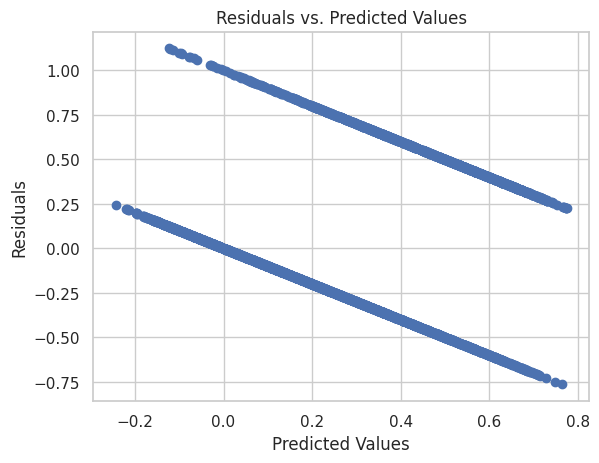

In [105]:
# Checking for linearity by examining the residuals
y_pred_train = linear_model.predict(X_train)
residuals_train = y_train - y_pred_train

# Ploting residuals against predicted values to check for linearity
plt.scatter(y_pred_train, residuals_train)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

The **normality of residuals** assumption fails since QQ plot does not follow a 45 degree line (But not too bad).

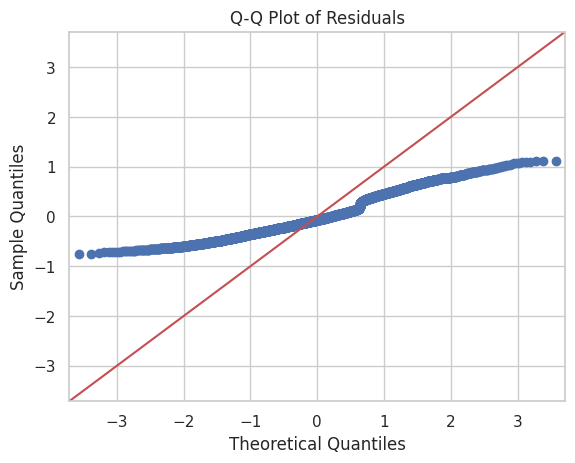

In [106]:
# Check for normality of errors
sm.qqplot(residuals_train, line='45')  # line='45' adds a reference line
plt.title('Q-Q Plot of Residuals')
plt.show()

The **independece** assumption passes as signified by a Durbin Watson test value of close to 2 (see model fit table above).

The **multicollinearity** assumption also passes since all features with VIF > 10 were dropped in the EDA phase.

## Logistic Regression

In [99]:
# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train).fit()

# Predict the probabilities
y_pred_prob = logit_model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.411965
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 5625
Model:                          Logit   Df Residuals:                     5603
Method:                           MLE   Df Model:                           21
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.2826
Time:                        05:54:20   Log-Likelihood:                -2317.3
converged:                       True   LL-Null:                       -3230.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.6374      

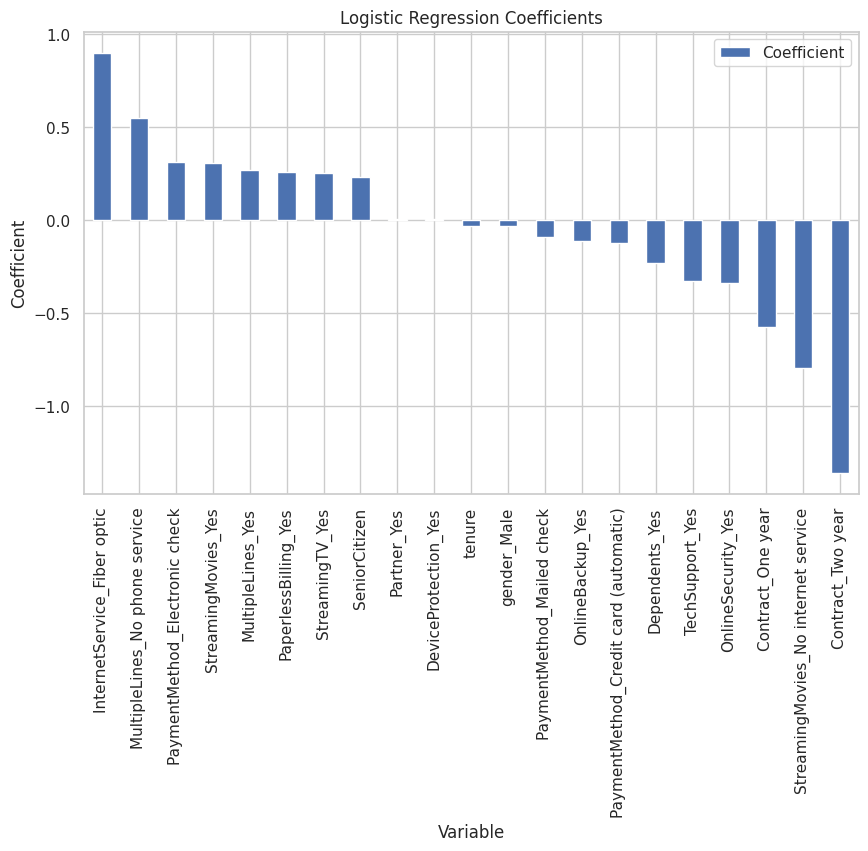

In [97]:
# plot the coeficients of the model for better visual
coef_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': logit_model.params[1:]})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
coef_df.plot(kind='bar', x='Variable', y='Coefficient', figsize=(10, 6))
plt.title('Logistic Regression Coefficients')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()

> Model Coeficient Interpretation

Holding all else constant ->

Intercept: The intercept is -0.6374. This is the log-odds of churn when all predictor variables are zero.


SeniorCitizen: The coefficient is 0.2317. Being a senior citizen increases the log-odds of churn by 0.2317.


tenure: The coefficient is -0.0347. Each additional month of tenure decreases the log-odds of churn by 0.0347.


gender_Male: The coefficient is -0.0347. Being male decreases the log-odds of churn by 0.0347, but this effect is not statistically significant (p-value = 0.634).


Partner_Yes: The coefficient is 0.0077. Having a partner increases the log-odds of churn by 0.0077, but this effect is not statistically significant (p-value = 0.930).


Dependents_Yes: The coefficient is -0.2336. Having dependents decreases the log-odds of churn by 0.2336.


MultipleLines_No phone service: The coefficient is 0.5497. Not having phone service increases the log-odds of churn by 0.5497.


MultipleLines_Yes: The coefficient is 0.2680. Having multiple lines increases the log-odds of churn by 0.2680.


InternetService_Fiber optic: The coefficient is 0.9002. Using fiber optic internet increases the log-odds of churn by 0.9002.


OnlineSecurity_Yes: The coefficient is -0.3374. Having online security decreases the log-odds of churn by 0.3374.


OnlineBackup_Yes: The coefficient is -0.1155. Having online backup decreases the log-odds of churn by 0.1155, but this effect is not statistically significant (p-value = 0.178).


DeviceProtection_Yes: The coefficient is 0.0063. Having device protection increases the log-odds of churn by 0.0063, but this effect is not statistically significant (p-value = 0.943).


TechSupport_Yes: The coefficient is -0.3263. Having tech support decreases the log-odds of churn by 0.3263.


StreamingTV_Yes: The coefficient is 0.2516. Having streaming TV increases the log-odds of churn by 0.2516.


StreamingMovies_No internet service: The coefficient is -0.7945. Not having internet service decreases the log-odds of churn by 0.7945.


StreamingMovies_Yes: The coefficient is 0.3049. Having streaming movies increases the log-odds of churn by 0.3049.


Contract_One year: The coefficient is -0.5737. Having a one-year contract decreases the log-odds of churn by 0.5737.


Contract_Two year: The coefficient is -1.3574. Having a two-year contract decreases the log-odds of churn by 1.3574.


PaperlessBilling_Yes: The coefficient is 0.2601. Using paperless billing increases the log-odds of churn by 0.2601.


PaymentMethod_Credit card (automatic): The coefficient is -0.1236. Using automatic credit card payments decreases the log-odds of churn by 0.1236, but this effect is not statistically significant (p-value = 0.335).


PaymentMethod_Electronic check: The coefficient is 0.3134. Using electronic checks increases the log-odds of churn by 0.3134.


PaymentMethod_Mailed check: The coefficient is -0.0941. Using mailed checks decreases the log-odds of churn by 0.0941, but this effect is not statistically significant (p-value = 0.462).

> Model performance on test data

In [70]:
# Calculate accuracy on test data
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

# Logistic regression assumptions

Accuracy: 0.7910447761194029


> Model Assumptions Check

Linearity assumption passes as we can observe a linear relationship between tenure and the log odds of churn.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


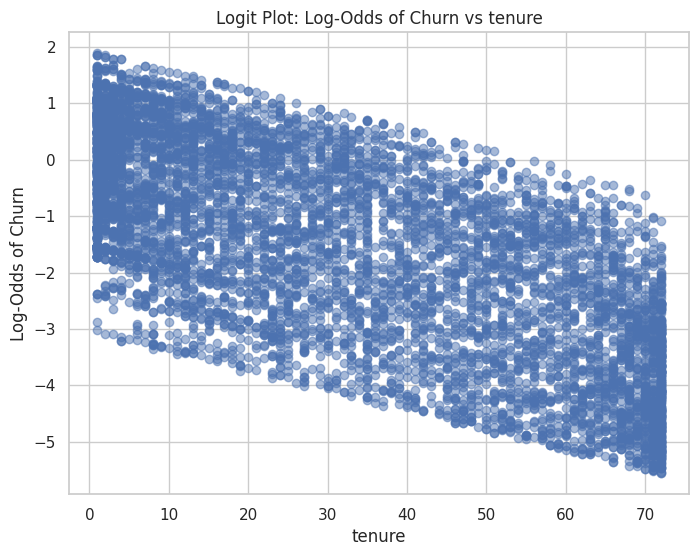

In [100]:
# Fit logistic regression model
log_model = LogisticRegression()
log_model.fit(X, y)

# Get predicted probabilities
probs = log_model.predict_proba(X)[:, 1]

# Compute the logit (log-odds)
logit_vals = np.log(probs / (1 - probs))

# Plot logit vs each continuous feature to check linearity
for i, feature in enumerate(['tenure']):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[feature], logit_vals, alpha=0.5)
    plt.title(f'Logit Plot: Log-Odds of Churn vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Log-Odds of Churn')
    plt.show()

A signifincant influential point can not be seen in the cooks distance plot below, therefore our model passes the No Outliers or Highly Influential Points assumption.

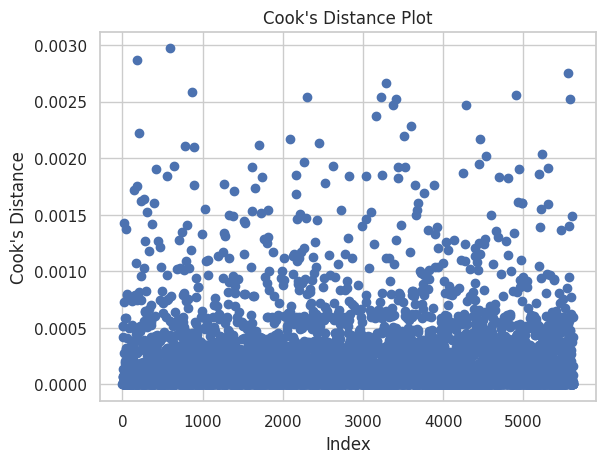

In [110]:
# Calculate Cook's distance
influence = logit_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot cooks distance
plt.scatter(range(len(cooks_d)), cooks_d)
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title('Cook\'s Distance Plot')
plt.show()

The multicollinearity assumption was also passed, since all features with vif > 10 were already dropped in the EDA section.

The indepence assumption was also passed.

## Generalize Additive Models (GAMs)

> Reprocessing the data for LogisticGAM

In [112]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# we can drop the customerid column as it should give us no new info
df = df.drop(['customerID', 'PhoneService', 'MonthlyCharges', 'TotalCharges'], axis=1)

df.dropna(inplace=True)

for c in df.columns:
    if c != 'trnure':
        df[c] = df[c].astype('category').cat.codes

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,0,1,0,1,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,0,34,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,0,2,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,45,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,0,2,0,1,0,0,0,0,0,0,0,1,2,1


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09
<ipython-input-72-aba2d984bb39>:24: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     32.3874
Link Function:                        LogitLink Log Likelihood:                                 -2245.4649
Number of Samples:                         5634 AIC:                                             4555.7046
                                                AICc:                                            4556.1147
                                                UBRE:                                               2.8132
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3112
Feature Function                  Lam

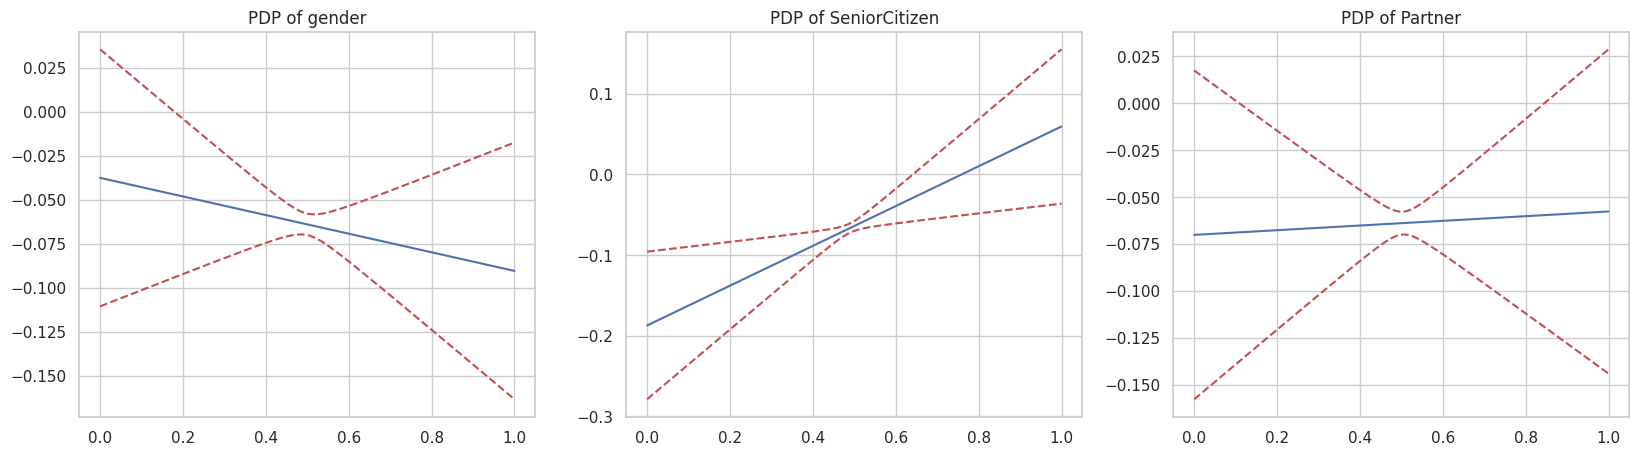

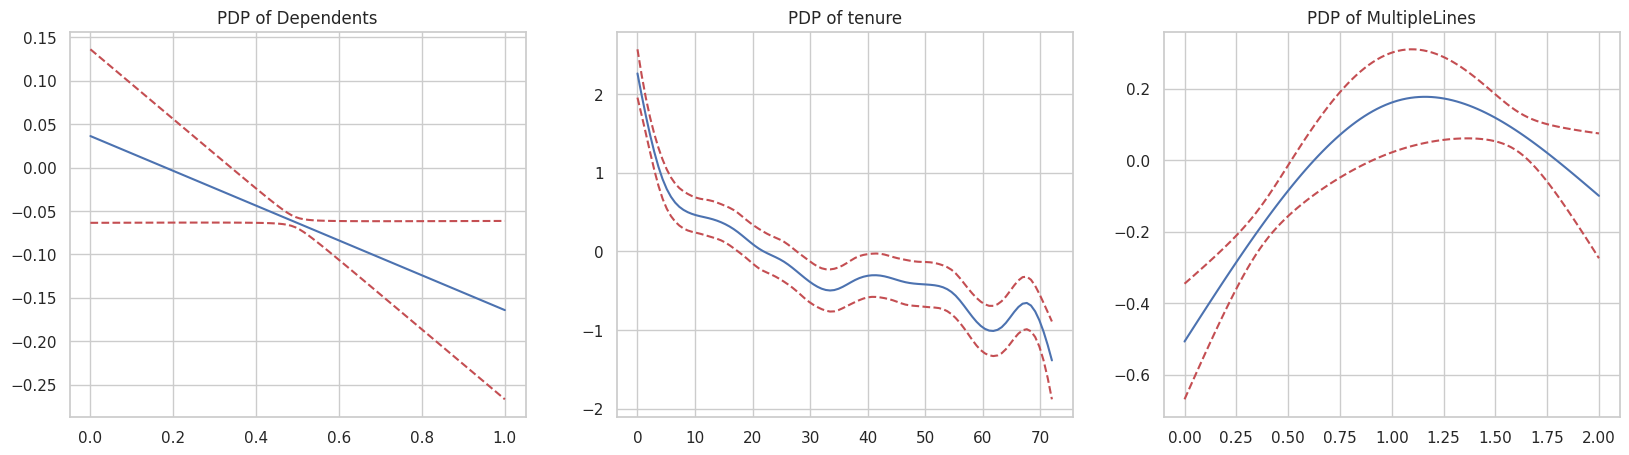

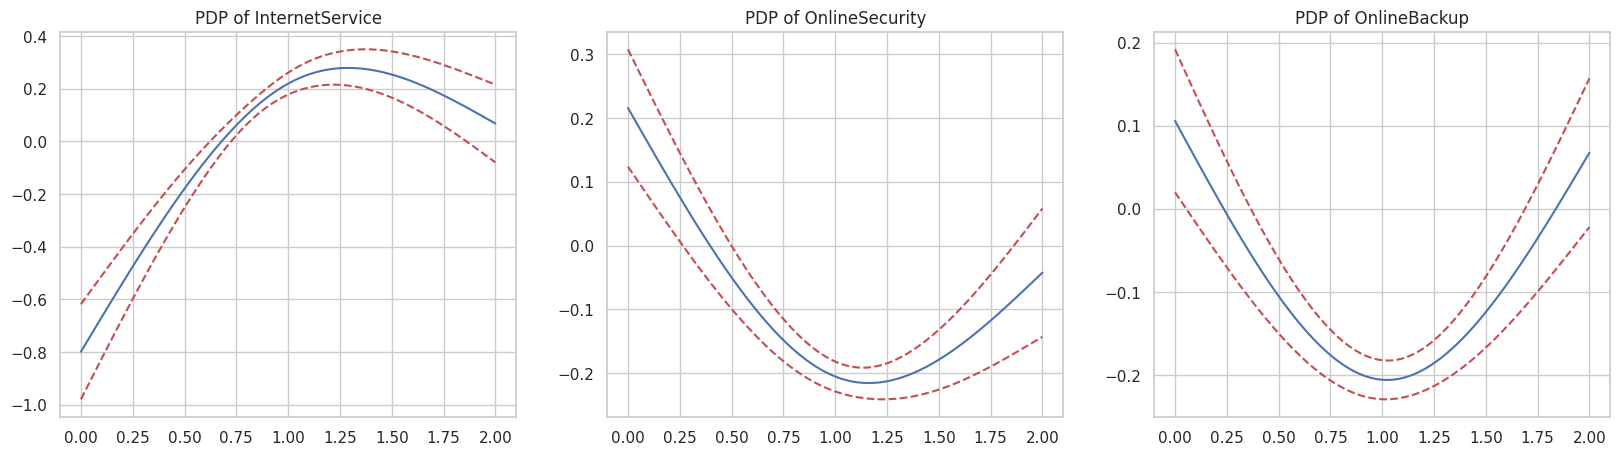

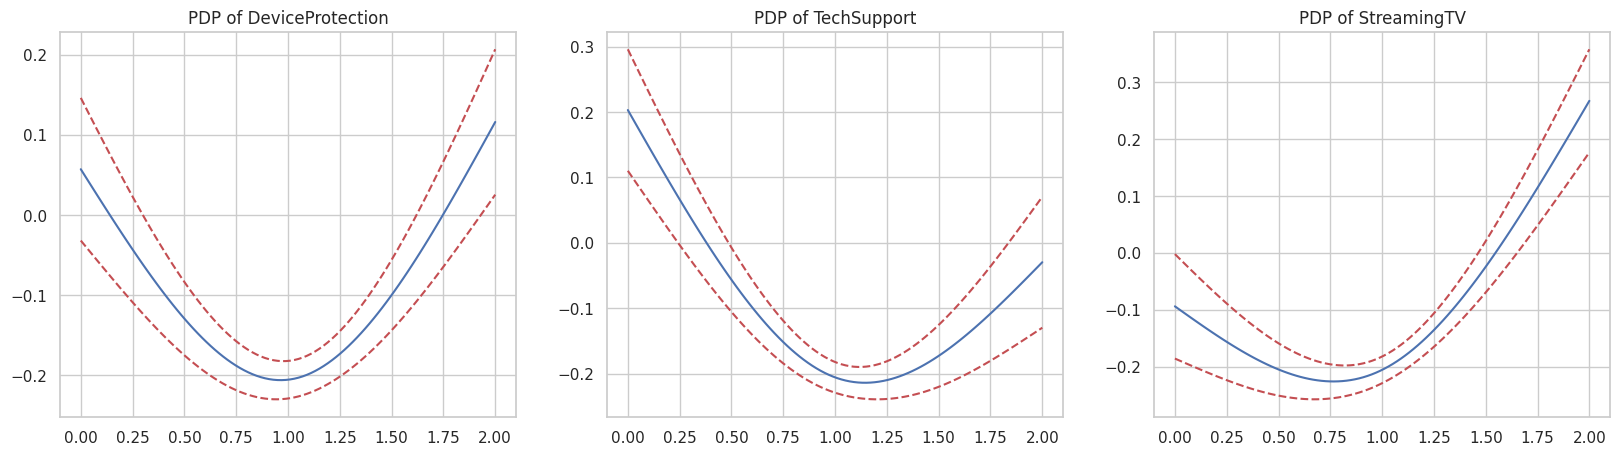

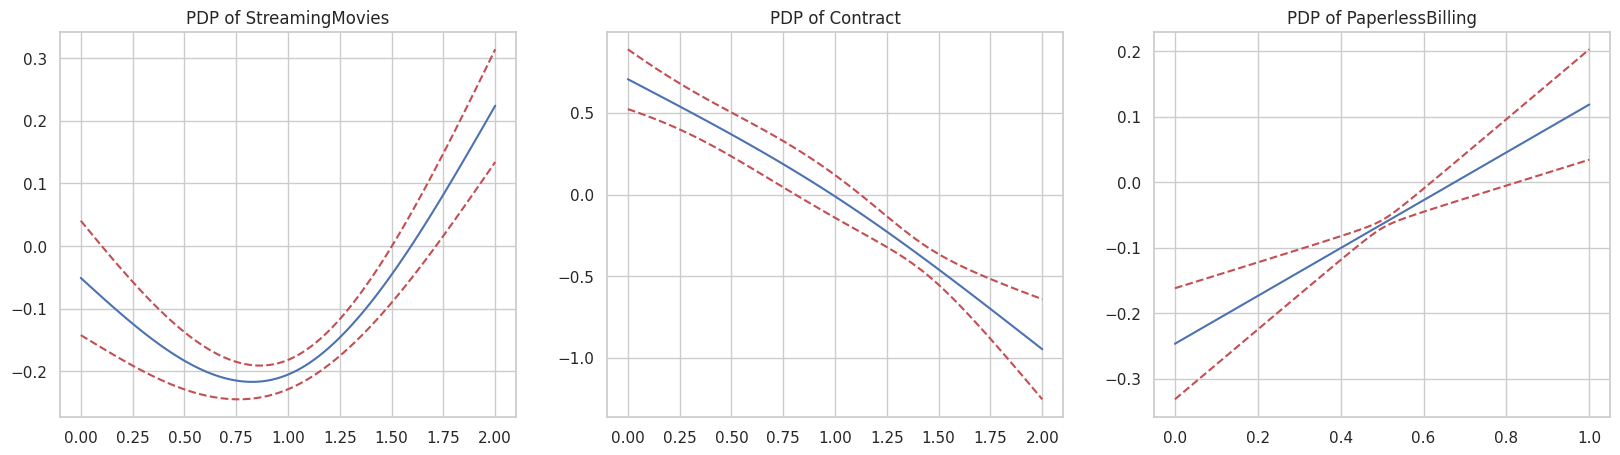

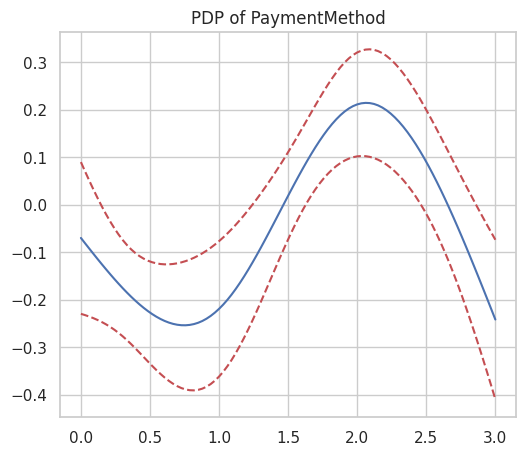

In [72]:
# building the GAM equation
terms = (
    s(0)
    + s(1)
    + s(2)
    + s(3)
    + s(4)
    + s(5)
    + s(6)
    + s(7)
    + s(8)
    + s(9)
    + s(10)
    + s(11)
    + s(12)
    + s(13)
    + s(14)
    + s(15)
)

gam = LogisticGAM(terms=terms)
gam.gridsearch(X_train.values, y_train.values)

print(gam.summary())

# Making Partial dependence plot for each feature
for i, term in enumerate(X.columns):
    if i % 3 == 0:  # Start a new row for every 3 plots
      plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, (i % 3) + 1)

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=0.95)

    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c="r", ls="--")

    if i < len(X.columns):
        plt.title(f'PDP of {X.columns[i]}')

plt.show()

> GAM model intepretation

To interpret the results of the GAM model we have to look at the partial dependance plots above. The partial dependance plots show how the log odd of churn change for a given feature, as we move that feature along the X axis, and holding all other features constant.


> Lets check model performance on test data

In [73]:
# Predict class labels on test set
y_pred = gam.predict(X_test.values)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data: {accuracy:.4f}')

Accuracy on test data: 0.7913


> GAM Assumption check

GAM models are the most robust to assumptions amongst the models we explored today and therefore require the least oversight.

The VIF assumption was met in the EDA process (although we kept come categorical features intact).

The Partial dependence plots suggest smooth spline fits, which exhibit how we are able to take advantage of GAMs nonlinear properties.

## Final Comparison

In terms of raw performance on the held-out test set, Generalized Additive Models (GAMs) slightly outperform Logistic Regression, which in turn performs marginally better than Linear Regression. Regarding interpretability, Linear Regression is the most straightforward, allowing us to directly interpret the coefficients as changes in the probability of churn. Next is Logistic Regression, which remains quite interpretable but requires us to understand coefficients as changes in the log odds of churn. GAMs are also interpretable, but their interpretation relies on partial dependence plots, which typically demand more time and effort.

When examining key assumptions, Linear Regression fails to meet several, while both Logistic Regression and GAMs pass. The primary strength of Linear Regression is its unparalleled interpretability, though its main weakness is its unsuitability for binary target variables. Logistic Regression effectively extends Linear Regression to binary outcomes, but it sacrifices some interpretability by transitioning from real-world effects to log odds. GAMs excel at modeling non-linear relationships between the target and features, but they rank lowest in interpretability among the three, though they still maintain good interpretability.

For the current analysis, the company should utilize the Logistic Regression model to address their churn rate. This recommendation stems from the invalidation of the Linear Regression model due to numerous assumption violations and the limited performance improvement of the GAM model relative to its interpretability trade-off.

## Reference

https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/interpretable-ml-example-notebooks/regression-interpretability.ipynb#scrollTo=zQZOny5qCj2N

https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/interpretable-ml-example-notebooks/generalized-models-interpretability.ipynb#scrollTo=xqhUakIZIdfE